In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# ML
from decomposition import IterativeSparseKPCA
from kernels import build_kernel, linear_kernel, gaussian_kernel

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5

# Initial setup

In [2]:
# Load train and test sets
train_idxs = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
test_idxs = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_structures = train_idxs.size + test_idxs.size

In [3]:
# Set structure labels for loading from the HDF5 file
n_digits = len(str(n_structures - 1))
datasets = [str(i).zfill(n_digits) for i in train_idxs]

In [4]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [5]:
n_kpca = 100

# Functions

In [7]:
def transform_iskpca_oos(cutoff, datasets,
                         soaps_file, ref_soaps_file, 
                         rep_idxs_file, model_file,
                         iskpca_env_file, iskpca_struct_file, 
                         work_dir='.'):
    
    # Read OOS SOAPs
    soaps = load_structures_from_hdf5(soaps_file, datasets=None, concatenate=False)
    n_structures = len(soaps)
    n_digits = len(str(n_structures - 1))
    
    # Load reference SOAPs
    representative_soaps = load_structures_from_hdf5(ref_soaps_file, datasets=datasets, concatenate=True)
 
    # Build representative SOAPs from training set (indices are relative to the training set)
    representative_idxs = np.loadtxt(rep_idxs_file, usecols=0, dtype=int)
    representative_soaps = representative_soaps[representative_idxs, :]
    
    # Unpickle the kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
    
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Unpickle the reference models
    with open(iskpca_env_file, 'r') as f:
        iskpca_environments_dict = json.load(f)        
    
    with open(iskpca_struct_file, 'r') as f:
        iskpca_structures_dict = json.load(f)
    
    # Turn lists into arrays
    for k, v in iskpca_environments_dict.items():
        if isinstance(v, list):
            iskpca_environments_dict[k] = np.array(v)
        
    for k, v in iskpca_structures_dict.items():
        if isinstance(v, list):
            iskpca_structures_dict[k] = np.array(v)
    
    # Set model attributes
    iskpca_environments = IterativeSparseKPCA()
    iskpca_environments.__dict__ = iskpca_environments_dict
       
    iskpca_structures = IterativeSparseKPCA()
    iskpca_structures.__dict__ = iskpca_structures_dict

    # Initialize the KPCA output
    g = h5py.File(f'{work_dir}/kpca_environments.hdf5', 'w')
    h = h5py.File(f'{work_dir}/kpca_structures.hdf5', 'w')
    
    # Save kernel parameters to the HDF5 files
    for file_obj in (g, h):
        file_obj.attrs['kernel_type'] = kernel_type
        file_obj.attrs['gamma'] = gamma        
    
    # Transform the data and save
    for sdx, soap in enumerate(tqdm(soaps)):
        KNMi = build_kernel(soap, representative_soaps,
                            kernel=kernel_type, gamma=gamma)
        kpcai_environments = iskpca_environments.transform(KNMi)
        kpcai_structures = iskpca_structures.transform(np.mean(KNMi, axis=0))
        g.create_dataset(str(sdx).zfill(n_digits), data=kpcai_environments)
        h.create_dataset(str(sdx).zfill(n_digits), data=kpcai_structures)
        
    g.close()
    h.close()

# DEEM_10k

In [7]:
for cutoff in cutoffs:
    
    # Set data directory
    data_dir = f'../Processed_Data/DEEM_10k/Models/{cutoff}'
    
    # Set working directory
    work_dir = f'../Processed_Data/DEEM_10k/Data/{cutoff}'
    if not os.path.exists(work_dir):
        os.mkdir(work_dir)
    
    soaps_file = f'{work_dir}/soaps.hdf5'
    rep_idxs_file = f'{work_dir}/FPS_representatives.idxs'
    model_file = f'{data_dir}/volumes_mae_parameters.json'
    iskpca_env_file = f'{data_dir}/iskpca_environments.json'
    iskpca_struct_file = f'{data_dir}/iskpca_structures.json'
        
    # Initialize SOAPs and KPCAs
    soaps = load_structures_from_hdf5(soaps_file, datasets=None, concatenate=False)

    # Build representative SOAPs from training set (indices are relative to the training set)
    representative_idxs = np.loadtxt(rep_idxs_file, usecols=0, dtype=int)
    representative_soaps = np.vstack([soaps[i] for i in train_idxs])
    representative_soaps = representative_soaps[representative_idxs, :]
    
    # Load kernel parameters (use kernel optimized for volume as benchmark)
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
    
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Build representative kernel
    KMM = build_kernel(representative_soaps, representative_soaps,
                       kernel=kernel_type, gamma=gamma)
    
    # Initialize sparse KPCA for environments
    iskpca_environments = IterativeSparseKPCA(n_kpca=n_kpca)
    iskpca_environments.initialize_fit(KMM)
    
    # Initialize sparse KPCA for structures
    iskpca_structures = IterativeSparseKPCA(n_kpca=n_kpca)
    iskpca_structures.initialize_fit(KMM)
    
    # Fit the sparse KPCA
    for soap in tqdm(soaps):
        KNMi = build_kernel(soap, representative_soaps,
                            kernel=kernel_type, gamma=gamma)
        iskpca_environments.fit_batch(KNMi)
        iskpca_structures.fit_batch(np.mean(KNMi, axis=0))
        
    # Finalize the KPCA fitting
    iskpca_environments.finalize_fit()
    iskpca_structures.finalize_fit()
    
    # Prepare the models for saving on disk
    # Copy the dict so we can make the numpy arrays lists
    iskpca_environments_dict = iskpca_environments.__dict__.copy()
    iskpca_structures_dict = iskpca_structures.__dict__.copy()

    # Convert arrays to lists
    for k, v in iskpca_environments_dict.items():
        if isinstance(v, np.ndarray):
            iskpca_environments_dict[k] = v.tolist()
            
    for k, v in iskpca_structures_dict.items():
        if isinstance(v, np.ndarray):
            iskpca_structures_dict[k] = v.tolist()
    
    # Pickle the environment-based model
    with open(iskpca_env_file, 'w') as f:
        json.dump(iskpca_environments_dict, f)
    
    # Pickle the structure-based model
    with open(iskpca_struct_file, 'w') as f:
        json.dump(iskpca_structures_dict, f)
    
    # Initialize the KPCA output
    g = h5py.File(f'{work_dir}/kpca_environments.hdf5', 'w')
    h = h5py.File(f'{work_dir}/kpca_structures.hdf5', 'w')
    
    # Save kernel parameters to HDF5 files
    for file_obj in (g, h):
        file_obj.attrs['kernel_type'] = kernel_type
        file_obj.attrs['gamma'] = gamma
    
    # Transform the data and save
    for sdx, soap in enumerate(tqdm(soaps)):
        KNMi = build_kernel(soap, representative_soaps,
                            kernel=kernel_type, gamma=gamma)
        kpcai_environments = iskpca_environments.transform(KNMi)
        kpcai_structures = iskpca_structures.transform(np.mean(KNMi, axis=0))
        g.create_dataset(str(sdx).zfill(n_digits), data=kpcai_environments)
        h.create_dataset(str(sdx).zfill(n_digits), data=kpcai_structures)
        
    g.close()
    h.close()
    
    # Delete SOAPs so we aren't carrying them around
    del soaps

In [ ]:
# Build unique environments
max_unique = 75000 # "Safety" measure
for cutoff in cutoffs:
    work_dir = f'../Processed_Data/DEEM_10k/Data/{cutoff}'
    
    # Load SOAPs
    kpcas = load_structures_from_hdf5(f'{work_dir}/kpca_environments.hdf5', datasets=None, concatenate=True)    
    
    # Get unique structures from FPS (indices are relative to the whole dataset)
    unique, distances = FPS(kpcas, n=max_unique)
    np.savetxt(f'{work_dir}/FPS_unique_kpca.idxs',
               np.stack((unique, distances), axis=1), fmt='%6d\t%.18e')
    
    # Delete the SOAPs so we aren't carrying them around
    del kpcas

# IZA_226 on DEEM_10k

In [8]:
for cutoff in cutoffs:
    
    # Set the working directory
    work_dir = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}'
    if not os.path.exists(work_dir):
        os.mkdir(work_dir)
        
    # Set the required files
    soaps_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    ref_soaps_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
    rep_idxs_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_representatives.idxs'
    model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'
    iskpca_env_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/iskpca_environments.json'
    iskpca_struct_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/iskpca_structures.json'
       
    # Compute the SKPCA
    transform_iskpca_oos(cutoff, datasets,
                         soaps_file, ref_soaps_file, 
                         rep_idxs_file, model_file,
                         iskpca_env_file, iskpca_struct_file, 
                         work_dir=work_dir)

In [ ]:
# Build unique environments
for cutoff in cutoffs:
    work_dir = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}'
    
    # Load SOAPs
    kpcas = load_structures_from_hdf5(f'{work_dir}/kpca_environments.hdf5', datasets=None, concatenate=True)    
    
    # Get unique structures from FPS
    unique, distances = FPS(kpcas, n=-1)
    np.savetxt(f'{work_dir}/FPS_unique_kpca.idxs',
               np.stack((unique, distances), axis=1), fmt='%6d\t%.18e')
    
    # Delete SOAPs so we aren't carrying them around
    del kpcas

# COD_196 on DEEM_10k

In [9]:
for cutoff in cutoffs:
    
    # Set the working directory
    work_dir = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}'
    if not os.path.exists(work_dir):
        os.mkdir(work_dir)
        
    # Set the required files
    soaps_file = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    ref_soaps_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
    rep_idxs_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_representatives.idxs'
    model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'
    iskpca_env_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/iskpca_environments.json'
    iskpca_struct_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/iskpca_structures.json'
       
    # Compute the SKPCA
    transform_iskpca_oos(cutoff, datasets,
                         soaps_file, ref_soaps_file, 
                         rep_idxs_file, model_file,
                         iskpca_env_file, iskpca_struct_file, 
                         work_dir=work_dir)

In [ ]:
# Build unique environments
for cutoff in cutoffs:
    work_dir = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}'
    
    # Load SOAPs
    kpcas = load_structures_from_hdf5(f'{work_dir}/kpca_environments.hdf5', datasets=None, concatenate=True)    
    
    # Get unique structures from FPS
    unique, distances = FPS(kpcas, n=-1)
    np.savetxt(f'{work_dir}/FPS_unique_kpca.idxs',
               np.stack((unique, distances), axis=1), fmt='%6d\t%.18e')
    
    # Delete SOAPs so we aren't carrying them around
    del kpcas

# TESTING

In [41]:
deem_kpca = load_structures_from_hdf5('../Processed_Data/DEEM_10k/Data/3.5/kpca_structures.hdf5',
                                      datasets=None, concatenate=True)
iza_kpca = load_structures_from_hdf5('../Processed_Data/IZA_226onDEEM_10k/Data/3.5/kpca_structures.hdf5',
                                     datasets=None, concatenate=True)
cod_kpca = load_structures_from_hdf5('../Processed_Data/COD_196onDEEM_10k/Data/3.5/kpca_structures.hdf5',
                                     datasets=None, concatenate=True)

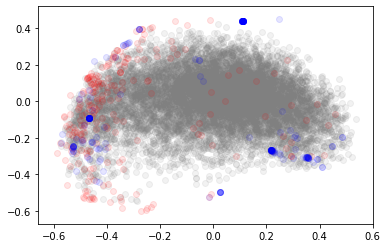

In [42]:
import matplotlib.pyplot as plt

plt.scatter(deem_kpca[:, 0], deem_kpca[:, 1], c='gray', alpha=0.1)
plt.scatter(iza_kpca[:, 0], iza_kpca[:, 1], c='red', alpha=0.1)
plt.scatter(cod_kpca[:, 0], cod_kpca[:, 1], c='blue', alpha=0.1)

plt.show()

In [27]:
from sklearn.decomposition import KernelPCA

with open('../Processed_Data/DEEM_10k/Models/3.5/energies_mae_parameters.json', 'r') as f:
    kernel_params = json.load(f)
    
print(kernel_params)

{'kernel_type': 'gaussian', 'gamma': 10.0, 'sigma': 0.001, 'reg': 0.001}


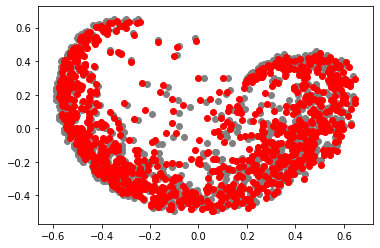

In [39]:
deem_soaps = load_structures_from_hdf5('../Processed_Data/DEEM_10k/Data/3.5/soaps.hdf5',
                                       datasets=None, concatenate=True)
iza_soaps = load_structures_from_hdf5('../Processed_Data/IZA_226onDEEM_10k/Data/3.5/soaps.hdf5',
                                       datasets=None, concatenate=True)
cod_soaps = load_structures_from_hdf5('../Processed_Data/COD_196onDEEM_10k/Data/3.5/soaps.hdf5',
                                      datasets=None, concatenate=True)
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=100)
T = kpca.fit_transform(deem_soaps[0::500])
Ti = kpca.transform(iza_soaps[0::500])
Tc = kpca.transform(cod_soaps[0::500])

plt.scatter(T[:, 0], T[:, 1], c='gray')
plt.scatter(deem_kpca[0::500, 0], deem_kpca[0::500, 1], c='red')
#plt.scatter(Ti[:, 0], Ti[:, 1], c='red')
#plt.scatter(Tc[:, 0], Tc[:, 1], c='blue')
plt.show()